# Classifying skin lesions using a convolutional neural network

The goal of this assignment is to design and implement a deep learning model
able to determine the category of a skin lesion from a dermoscopic image.

This is a _multiclass classification_ problem where the inputs are RGB
images; therefore, the most natural approach is to use a Convolutional Neural
Network (CNN) for classification.

In this document I will go through the different steps of the data analysis
pipeline, explaining the reasons behind the choices I made and their
consequences on the results of the experiments.

#### Summary

This report is organized as follows:  

1. [**Data exploration**](#Data-exploration)
1. [**(brief) Literature review**](#Literature-review)
1. [**Experiment design**](#Experiment-design)
1. [**Implementation details**](#Implementation-details)
1. [**Results**](#Results)
1. [**Conclusions**](#Conclusions)

## Data exploration
[back to top](#Summary)

#### Imports

In [1]:
%matplotlib inline

In [2]:
import pandas as pd

In [57]:
import matplotlib.pyplot as plt
import seaborn

In [4]:
import os
import sys

In [5]:
import numpy as np

In [6]:
import torchvision.transforms as transforms
import PIL

In [71]:
from tqdm import tqdm

In [7]:
# Add parent folder to system path to allow loading modules
sys.path.append("..")

Set up folders

In [8]:
DATA_FOLDER = "../data"
ANNOTATION_FILE_NAME = "HAM10000_metadata.csv"
LABEL_COLUMN = 'dx'

### Read annotations

In [9]:
annotation_df = pd.read_csv(os.path.join(DATA_FOLDER, ANNOTATION_FILE_NAME))

In [10]:
annotation_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

## Data exploration
[back to top](#Summary)

The very first step in most data analysis pipelines consists in
_looking at the dataset_ and trying to understand its characteristics, in order
to make the appropriate decisions when designing the experiments.

The following table and plot show the number of samples present in the dataset for each
class.

In [12]:
annotation_df.groupby(LABEL_COLUMN)['age'].describe()

,count,mean,std,min,25%,50%,75%,max
dx,,,,,,,,
akiec,327.0,66.529052,11.476232,30.0,60.0,70.0,75.0,85.0
bcc,514.0,66.828794,13.656959,20.0,60.0,70.0,75.0,85.0
bkl,1089.0,64.283747,14.120715,0.0,55.0,65.0,75.0,85.0
df,115.0,53.043478,13.551326,25.0,45.0,50.0,65.0,80.0
mel,1111.0,60.679568,15.189847,5.0,50.0,60.0,70.0,85.0
nv,6660.0,46.477477,15.183275,0.0,35.0,45.0,55.0,85.0
vasc,142.0,51.373239,21.644651,0.0,40.0,55.0,70.0,85.0


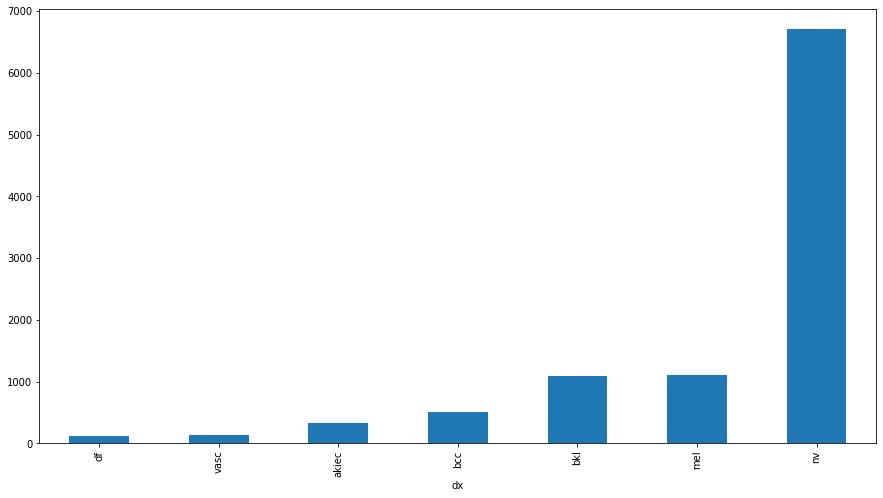

In [13]:
plt.figure(figsize=(15,8))
annotation_df.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(kind='bar')

This plot clearly shows that the dataset is *heavily inbalanced*: the most
represented class is by far **nv**, corresponding to *benign melanocytic nevi*, with
6660 samples, while the least represented class, **df** (*dermatofibromas*), has
only 115 samples in this dataset.


This was to be expected, since medical datasets often contain many more samples
of a given feature (in this case, skin lesions) *not* affected by a disease than
samples presenting signs of a medical condition.


Apart from the evident class inbalance, some of the classes (most of them,
actually) have a very small number of samples in absolute terms, which may lead
to severe problems in the training process, unless properly addressed.


Finally, a consideration on the goal of the task itself: normally the
performance of a model trained to solve a classification task is evaluated based
on its *accuracy*, that is the percentage of samples from a *test set* (that is
a set which hasn't been used **in any way** during the training) which is
correctly classified by the model.
This is fine for most cases (and as a matter of fact it is one of the metrics
used in this analysis), however it is important to take into account the nature
of this problem, and in particular what the consequences of an error would be, when commenting results.
The samples present in the set can be grouped in **two** categories: lesions
that are **malignant** (or eventually might develop into malignant ones), and
those which are **benign**. With that in mind, it is clear that
**type II errors** (false negatives, that is classifying a malignant lesion as a
benign one) should be minimized, at the cost of increasing the occurrence of
**type I errors** (false positives), since the consequences would be very different
for the two types of mistakes.

These are crucial aspects of this particular dataset, which need to be
taken into consideration when choosing the parameters for the training process
(hyperparameters and overall training strategy). All of the choices made to
address the issues discussed above are explained in detail in section
[experiment design](#Experiment-design).

### Visualize sample images

Since the input are RGB images, visualizing a few of them for each class might
provide some useful insight.

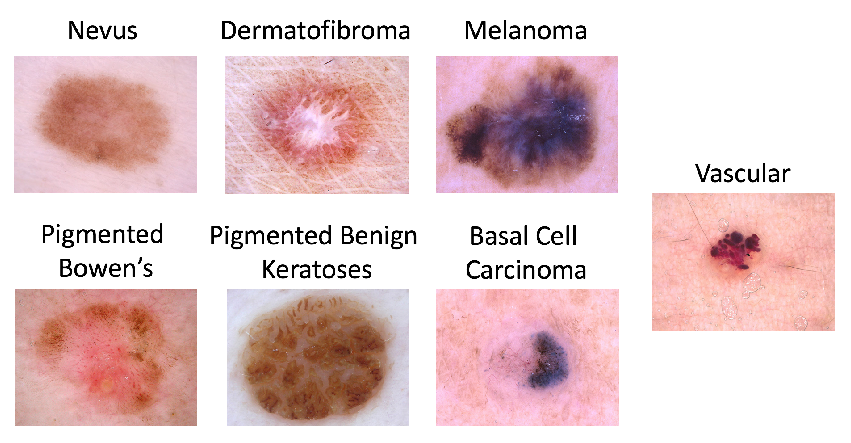

In [14]:
sample_image = plt.imread("../lesions.png")
plt.figure(figsize=(15,8))
plt.axis('off')
plt.imshow(sample_image);

Display a few images from the dataset on a grid in order to visually check their characteristics

In [15]:
from lib.dataset import HAM10000, create_train_val_split, read_meta_data

In [16]:
train_ids, val_ids = create_train_val_split(DATA_FOLDER, 0.8, 0.2)

In [17]:
# Order so that classes that get confused are shown close to one another
class_labels = ['akiec', 'bkl', 'bcc', 'df', 'mel', 'nv', 'vasc']

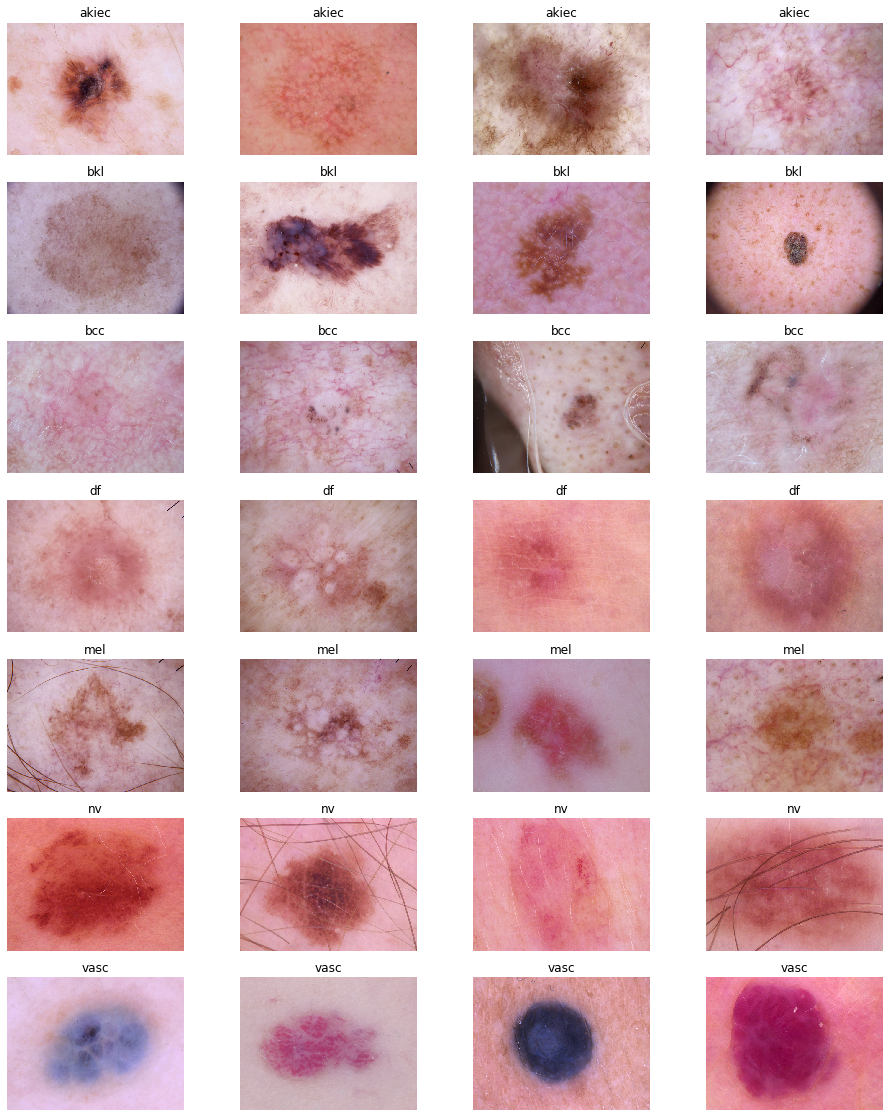

In [18]:
n_rows = len(class_labels)
n_cols = 4

f, axes = plt.subplots(n_rows, n_cols, figsize=(16, 20))

for x, l in enumerate(class_labels):
    samples4 = annotation_df[(annotation_df['dx'] == l)].sample(frac=1.0, random_state=9876).iloc[:4]
    for y, im_id in enumerate(samples4['image_id']):
        img = plt.imread(os.path.join(DATA_FOLDER, "{}.jpg".format(im_id)))
        axes[x, y].axis('off')
        axes[x, y].imshow(img)
        axes[x, y].set_title(l)

While I'm not a physician myself, I can make a few general considerations on
some characteristics of the images in this dataset:

* Some of the lesions categories such as *vascular lesions* (class label
  **vasc**) are (somewhat) easily distinguishable from the others because of
  their color or texture, whereas others seem to be less easy to tell apart (for
  instance *dermatofibromas* (**df**) and *melanomas* (**mel**). Therefore, it is
  reasonable to expect that samples belonging to one of these two classes might be mixed up more easily.

* The color of the lesion seems to be somewhat important in determining the
  class of the lesion; this should be taken into consideration when applying any
  kind of transformation to the color space of the images.
  
* Samples from different categories seem to present differences mainly in terms of *texture pattern*, which are relatively low-level features (as opposed to differences in categories in "traditional" classification problems, where objects from different classes, e.g. *car* and *motorcycle* are distinguishable because of higher level features). In convolutional neural networks, there is a relationship between the *complexity* of a feature and the *depth* of a layer: early layers of the network detect simple, low-level features such as *edges* and *blobs*, whereas layers deeper in the network detect more complex features such as elements which compose a complex object such as a person's face or a specific type of object. While I'm not exploring this aspect in this report, if I had to bet I would say that the most important features for this specific classification task are **mid-level features** such as *texture*, which correspond to filters of layers at a **medium depth** in the network.

## Literature review
[back to top](#Summary)

I searched on Google the terms `skin lesions classification convolutional neural network` and went through a couple of those.

Unsurprisingly, most of them were more or less similar to each other, the main differences being the network architecture (**Alexnet**, **Resnet{50,101,152}**, some variant of the **Inception network**...), the datasets used and the type of task they were trying to solve (some of them tried to discriminate between several categories of skin lesions whereas others tried to solve the binary classification task malignant/non-malignant).

I focused on one in particular, available at https://arxiv.org/pdf/1812.02316.pdf, since I found it to be very well written, plus the task the authors performed (multiclass classification) was similar to the one of this assignment and the overall approach very akin to what I would have done if I had to start from scratch.

In this paper the authors describe the results they obtained by training a CNN on a dataset obtained by merging three different datasets, for a total of 5286 images of varying quality divided in **twelve** categories.
They used a **ResNet152** architecture (replacing the last layer with one having 12 outputs) with the pre-trained weights trained on the ImageNet database, using data augmentation techniques to compensate for the lack of data.

They indicate all the hyperparameters they used to train their network, which I used as a starting point for my experiments, due to the similarities of the tasks.

The main metric they rely on to assess their model's performance is the **Area Under Curve** (AUC), that is the area under the ROC curve (https://it.wikipedia.org/wiki/Receiver_operating_characteristic), for each one of the twelve classes individually.

They report excellent results (AUC $\ge$ 0.90) for all of the twelve categories (except for the *wart* class, which had a slightly lower AUC score of 0.89).

## Experiment design
[back to top](#Summary)

In this section I will describe the different choices I made in designing the experiments.

### Training/validation split

The dataset was split in *training* and *validation* set based on the following considerations:

* The ratio of samples from each classes should be the same in both sets.
* Have enough samples for all categories (especially for the least represented ones) in the validation set, so that metrics on that set are stable enough to provide useful insight about how the training is proceeding.

The size of the validation set was chosen according to these points. 20% of all available samples ended up in the validation set, the remaining 80% in the training set.

Given the very limited amount of samples for some of the classes, I chose *not* to keep data aside for a *test set*, as I felt there wouldn't have been enough samples for some of the classes to provide a reliable estimate of the model's performance.

Instead, the network's performance will be evaluated considering (for each metric) the values computed on the validation set in the final epochs of training, knowing that this estimate will be *biased*, as the choice of hyperparameters will be guided by the algorithm's performances on _that_ set.

The auxiliary function used to produce the training/validation splits takes a seed for the random number generator as input, to guarantee the reproducibility of the experiment.

In [34]:
# Get training ids and validation ids
train_ids, val_ids = create_train_val_split(DATA_FOLDER, 0.8, 0.2, random_state=123)

In [35]:
print("Samples in training set: {}".format(len(train_ids)))
print("Samples in validation set: {}".format(len(val_ids)))

n_samples_total = len(val_ids) + len(train_ids)

print("Total samples: {}".format(n_samples_total))

# Sanity checks: union must be equal to total, intersection must be 0
assert (len(set(val_ids).union(set(train_ids))) == n_samples_total)
assert (len(set(val_ids).intersection(set(train_ids))) == 0)

Samples in training set: 8010
Samples in validation set: 2005
Total samples: 10015


In [36]:
data_df = read_meta_data(DATA_FOLDER)

data_train = data_df.loc[train_ids]
data_val = data_df.loc[val_ids]

#### Number of samples for each class in the validation set

In [37]:
data_val.groupby(LABEL_COLUMN)['age'].describe()

,count,mean,std,min,25%,50%,75%,max
dx,,,,,,,,
akiec,66.0,65.303030,10.701502,40.0,56.25,65.0,75.0,85.0
bcc,103.0,66.893204,13.212377,20.0,65.00,70.0,75.0,85.0
bkl,217.0,65.622120,13.426931,30.0,55.00,70.0,75.0,85.0
df,23.0,51.086957,13.052039,30.0,40.00,50.0,60.0,80.0
mel,223.0,60.470852,14.351690,25.0,55.00,60.0,70.0,85.0
nv,1329.0,46.376975,15.105805,0.0,35.00,45.0,55.0,85.0
vasc,29.0,48.448276,22.244720,0.0,30.00,55.0,60.0,85.0


#### Number of samples for each class in the training set

In [33]:
data_train.groupby(LABEL_COLUMN)['age'].describe()

,count,mean,std,min,25%,50%,75%,max
dx,,,,,,,,
akiec,261.0,66.839080,11.663098,30.0,60.0,70.0,75.0,85.0
bcc,411.0,66.812652,13.781799,25.0,60.0,70.0,77.5,85.0
bkl,872.0,63.950688,14.276058,0.0,55.0,65.0,75.0,85.0
df,92.0,53.532609,13.698842,25.0,45.0,52.5,65.0,80.0
mel,888.0,60.731982,15.400487,5.0,50.0,60.0,70.0,85.0
nv,5331.0,46.502532,15.203835,0.0,35.0,45.0,55.0,85.0
vasc,113.0,52.123894,21.524543,0.0,40.0,55.0,70.0,85.0


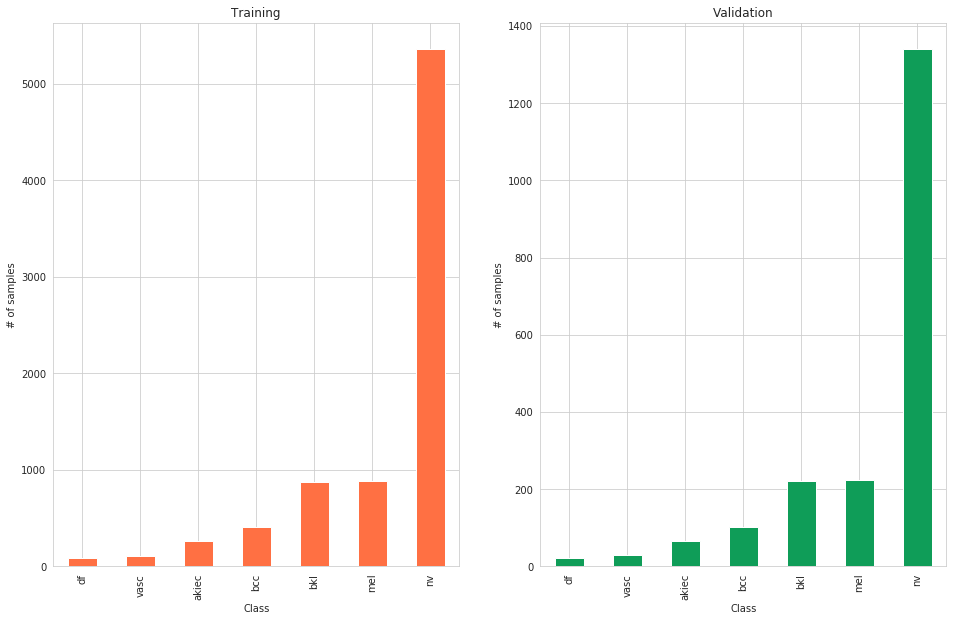

In [47]:
f, axes = plt.subplots(1, 2, figsize=(16, 10))

data_train.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(title="Training", kind='bar', color="#ff7043", ax=axes[0])
data_val.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(title="Validation", kind='bar', color='#0f9d58', ax=axes[1])

axes[0].set_xlabel("Class")
axes[1].set_xlabel("Class")

axes[0].set_ylabel("# of samples")
axes[1].set_ylabel("# of samples");

### Sampling strategy for training

In [68]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import WeightedRandomSampler

To tackle the issue of class imbalance, samples from the training set are sampled in a way such that in every batch (I use the term "batch" here in a broader sense) there is roughly the same amount of data points for each one of the seven classes.

From the implementation point of view, this is achieved by passing to the *DataLoader* an instance of class [`torch.utils.data.WeightedRandomSampler`](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler) (warning: the example provided in the documentation is counterintuitive), which samples from the availables elements of a set (in this case, the training set) given some predefined weights.

Each sample belonging to class $c$ is assigned a weight corresponding to $\frac{1}{f_c}$, where $f_c$ is the ratio of samples belonging to class $c$ in the training set. 

This is equivalent to duplicate samples from less represented classes until each class has the same amount of samples.

The following code shows an example of several batches of data being drawn using that sampler.

In [73]:
dataset_train = HAM10000(DATA_FOLDER, train_ids)

weights = dataset_train.make_weights_for_balanced_classes()

sampler = WeightedRandomSampler(weights, len(weights))

In [75]:
dataloader_train = DataLoader(dataset_train, 8, sampler=sampler, num_workers=4)

i = 0

# Initialize list for keeping track of counts
counts = [0] * 7

SAMPLE_ITERATIONS = len(dataloader_train) // 8

for data, target in tqdm(dataloader_train, total=SAMPLE_ITERATIONS):
# for a in tqdm(dataloader_train, total=SAMPLE_ITERATIONS):
    
    for c in target:
        counts[c] += 1
    
    i += 1

1002it [00:20, 48.07it/s]                        


In [77]:
for i, c in enumerate(dataset_train.get_class_map_dict()):
    print("# of samples for class {}:\t{}".format(c, counts[i]))

# of samples for class akiec:	1143
# of samples for class bcc:	1165
# of samples for class bkl:	1172
# of samples for class df:	1142
# of samples for class mel:	1143
# of samples for class nv:	1099
# of samples for class vasc:	1146


### Data augmentation

In [48]:
da_transforms = get_data_augmentation_transforms(4)

# Add ToPilImage for plotting
da_transforms = transforms.Compose([da_transforms, transforms.ToPILImage()]) 

In [49]:
dataset_train_augmented = HAM10000(DATA_FOLDER, train_ids, da_transforms)

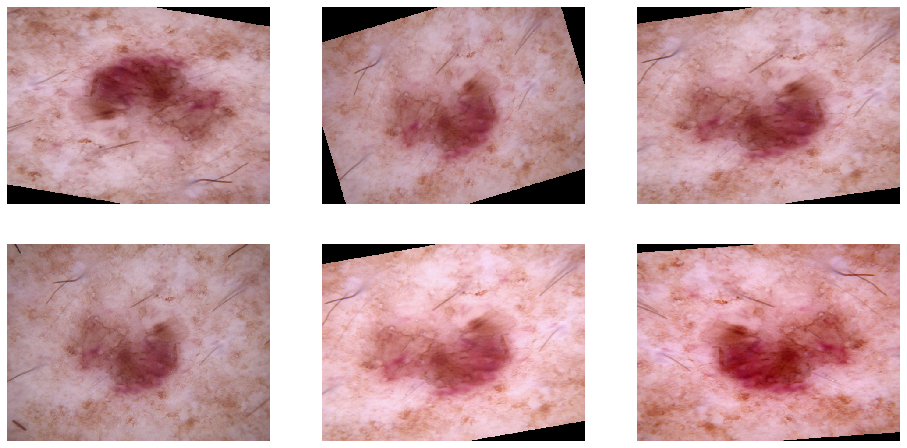

In [63]:
# Creates two subplots and unpacks the output array immediately
n_rows = 2
n_cols = 3
f, axes = plt.subplots(n_rows, n_cols, figsize=(16,8))
for ii in range(n_rows * n_cols):
    x = ii // n_cols
    y = ii % n_cols
    img, _ = dataset_train_augmented[0]
    axes[x, y].imshow(img)
    axes[x, y].grid(False)
    axes[x, y].axis('off')
    

### Scheduling experiments

### Monitoring experiments

Tensorboard

#### Metrics

* Training/Validation Loss
* Training/Validation Accuracy
* Class specific metrics:
    * Precision
    * Recall
    * ROC AUC
    

## Implementation details
[back to top](#Summary)

* A main python script to launch experiments
* A skeleton bash script to launch experiments
* The script prints the ETA of the experiment conclusion, which helps for scheduling experiments
* `at` used to schedule experiments, redirecting output/error to a `tmux` pane in order to monitor the execution

## Results
[back to top](#Summary)

### Best model hypermarameters

Here is the configuration of the 

 * Network architecture: **resnet50**
 * Use pretrained weights: **YES** (trained on Imagenet)
 * Freeze layers: **NO**
 * Initial learning rate: $\mathbf{10^{-5}}$
 * Batch size: $\mathbf{8}$

And here is the plot of loss

In [21]:
from lib.utils import plot_tf_log

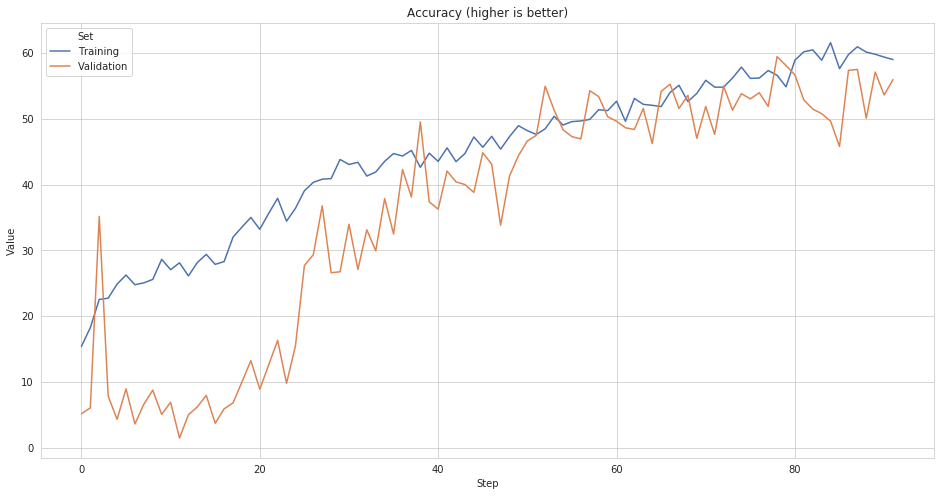

In [22]:
plt.figure(figsize=(16,8))
plot_tf_log(["../results/run6_train.csv", "../results/run6_val.csv"], "Accuracy (higher is better)")

Experiments have been performed on a PC with the following specs:

 * **CPU**: Intel(R) Core(TM) i7-9700K CPU @ 3.60GHz
 * **RAM**: 32 GB
 * **OS**: Ubuntu 18.04
 * **GPU**: NVIDIA RTX 2080 TI GPU
 
Each "epoch" (considering both training and the forward pass on the whole validation set) took roughly 2:35.

* confronto con i risultati della challenge https://challenge2018.isic-archive.com/leaderboards/

## Conclusions
[back to top](#Summary)

### Future work

* Use additional data from other datasets
* Include additional information (age) however be sure not to fixate on that...
* Choose different values for the learning rate of layers deeper in the network (as opposed to those in the first layers)
* Visualize the early layers in the DS and see if there is any significant difference from the ones coming from the pretrained network on IMGNET
* use an even more sophisticated architecture Inception-V3/4
* Experiment with lighter networks and see if it is possible to have it run with decent performances on embedded machines/mobiles
* GradCAM technique to see what the network is focusing on
* Analyze mislabeled samples
* Remove hair with algorithm